Problem Statement: Human Activity Recognition Time Series Classification (13 marks)
Human Activity Recognition (HAR) using smartphones dataset. Classifying the type of movement amongst six
categories:
1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying


1) IMPORT LIBRARY AND DATASET 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1762544806336905836]

In [ ]:

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=22af1cf773de3b79903d2d4d12ccc79fe8f7c46efddb7ede224e37e2f9d723df
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [ ]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function
mem_report()

CPU RAM Free: 12.7 GB


In [81]:
# Import Packages
import pandas as pd
from pandas import read_csv
from numpy import dstack
from numpy import array
from numpy import vstack
from pandas import DataFrame
from numpy import unique
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from numpy import mean
from numpy import std
from numpy import dstack
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt

PART 2 DATA PREPROCESSING

a) Load file 

In [82]:
def load_single_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

b) Load group

In [83]:
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	
	loaded = dstack(loaded)
	return loaded

c) Load dataset group

In [ ]:
!unzip HAR.zip

In [32]:
# load a dataset group, such as train or test
def load_dataset_group(groupname,relativedir):
	filepath = relativedir + groupname + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+groupname+'.txt', 'total_acc_y_'+groupname+'.txt', 'total_acc_z_'+groupname+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+groupname+'.txt', 'body_acc_y_'+groupname+'.txt', 'body_acc_z_'+groupname+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+groupname+'.txt', 'body_gyro_y_'+groupname+'.txt', 'body_gyro_z_'+groupname+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(relativedir + groupname + '/y_'+groupname+'.txt')
	return X, y

d) load the dataset, returns train and test X and y elements

In [33]:
def load_dataset(relativedir=''):
	# load all train
	trainX, trainy = load_dataset_group('train', relativedir + 'UCI HAR Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', relativedir + 'UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [55]:
import matplotlib.pyplot as plt  
  
# summarize the balance of classes in an output variable column
def class_wise_summary(data):
	# convert the numpy array into a dataframe
	df = DataFrame(data)
	# group data by the class value and calculate the number of rows
	counts = df.groupby(0).size()
	# retrieve raw rows
	counts = counts.values
	# summarize
	for i in range(len(counts)):
		percent = counts[i] / len(df) * 100
		print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]
# get all data for one subject
def data_for_label(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if y[i].any()==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series

# plot the data for one subject
def plot_subject(X, y):
	pyplot.figure()
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
  
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	pyplot.subplot(n, 1, n)
	pyplot.plot(y)
	pyplot.title('activity', y=0, loc='left')
	pyplot.show()

# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, n=10):
	pyplot.figure()
	# get unique subjects
	subject_ids = np.unique(sub_map[:,0])
	# enumerate subjects
	xaxis = None
	for k in range(n):
		sub_id = subject_ids[k]
		# get data for one subject
		subX, _ = data_for_subject(X, y, sub_map, sub_id)
		# total acc
		for i in range(3):
			ax = pyplot.subplot(n, 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			pyplot.hist(to_series(subX[:,:,i]), bins=100)
	pyplot.show()
 





3) data visualisation

In [56]:
trainX,trainy,textX,testy=load_dataset()




(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [57]:
class_wise_summary(trainy)

Class=1, total=6126, percentage=83.324
Class=2, total=1226, percentage=16.676


In [58]:
sub_map = load_single_file('UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


1
(7352, 128, 9) (7352, 6)


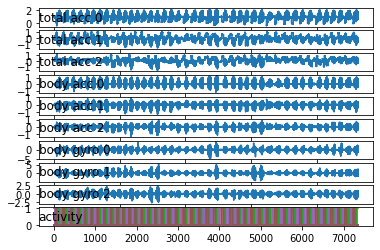

In [61]:
sub_map = load_single_file('UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map)
#print(train_subjects)
sub_id = train_subjects[0]
print(sub_id)
subX, suby = data_for_label(trainX, trainy, sub_map, 1)
print(subX.shape, suby.shape)
# plot data for label walking
plot_subject(subX, suby)



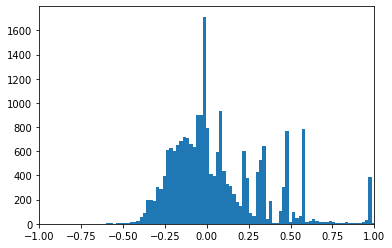

In [62]:
plot_subject_histograms(trainX, trainy, sub_map, sub_id)

In [107]:

def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy,history

In [108]:

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


Reason for adam optimiser ->

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems

dict_keys(['loss', 'accuracy'])


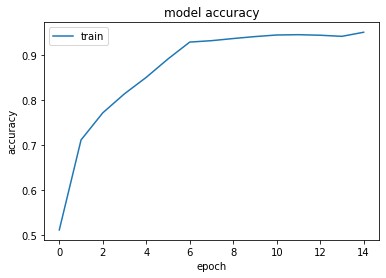

>#1: 90.261
dict_keys(['loss', 'accuracy'])


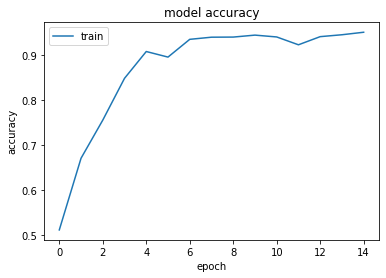

>#2: 90.974


In [110]:
scores = list()
for r in range(2):
    score,history = evaluate_model(trainX, trainy, textX, testy)
    score = score * 100.0
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print('>#%d: %.3f' % (r+1, score))
    scores.append(score)

In [112]:
summarize_results(scores)

[90.26128053665161, 90.97387194633484]
Accuracy: 90.618% (+/-0.356)


In [113]:
# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
 
	for r in range(repeats):
		score,history = evaluate_lstm_cnn_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
    
    
  
	# summarize results
	summarize_results(scores)
  


Develop a CNN-LSTM Network Model



In [114]:
def evaluate_lstm_cnn_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(
        TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, history

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
dict_keys(['loss', 'accuracy'])


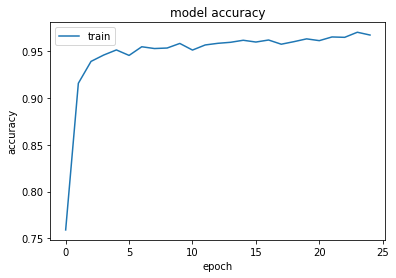

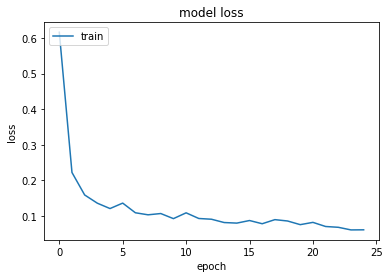

>#1: 90.295
dict_keys(['loss', 'accuracy'])


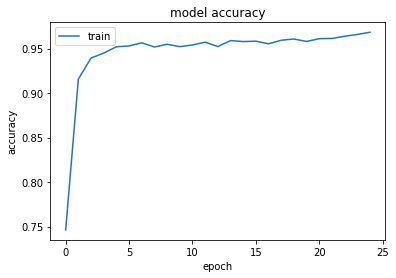

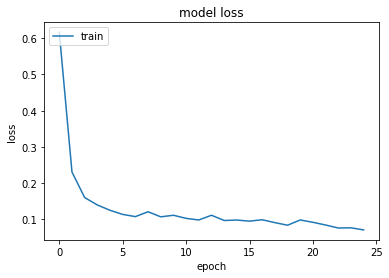

>#2: 91.653
[90.29521346092224, 91.65253043174744]
Accuracy: 90.974% (+/-0.679)


In [115]:

run_experiment(2)
